In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import seaborn as sns
import os
from tqdm import tqdm

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings(action='ignore')

/opt/conda/envs/beer/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [183]:
data_len = 10 * 1000000
num_users = 136677
num_items = 20108

sparsity = (1 - data_len / (num_users * num_items)) * 100
sparsity

99.63613885167887

## dataset

In [2]:
ratebeer = pd.read_csv("../data/train_ratebeer_without_text.csv")

In [66]:
# ratebeer = pd.read_json("../data/ratebeer_korea.json")

### 데이터 전처리

In [2]:
# data_dir = "../data"
# # preprocessed_output_dir = "../data/train"
# ratebeer = pd.read_json(os.path.join(data_dir, "raw_ratebeer.json"))

### 1. 결측치 제거 (label) reviewscore, beer_id NaN 제거

In [3]:
# # reviewscore
# print(ratebeer.reviewscore.isna().sum())

# # 인덱스 초기화
# ratebeer = ratebeer[~ratebeer.reviewscore.isna()]
# ratebeer.index = range(len(ratebeer))

28


In [4]:
# # reviewscore
# print(ratebeer.beer_id.isna().sum())

# # 인덱스 초기화
# ratebeer = ratebeer[~ratebeer.beer_id.isna()]
# ratebeer.index = range(len(ratebeer))

779


### 2. 리뷰 개수가 10개 미만인 유저 제거

In [5]:
# # 리뷰 개수 10개 이상인 유저 리스트
# over10user_list = (ratebeer["profile_name"].value_counts() >= 10).where(lambda x: x == True).dropna().index.tolist()

# # 리뷰 개수 10개 이상인 유저 리스트를 받아와서 해당 유저들로만 구성된 데이터셋으로 업데이트
# ratebeer = ratebeer[ratebeer["profile_name"].isin(over10user_list)]

# # 인덱스 초기화
# ratebeer = ratebeer[~ratebeer.reviewscore.isna()]
# ratebeer.index = range(len(ratebeer))

### 3. user_id 등록

In [6]:
# n_user = ratebeer.profile_name.nunique()
# print(f"n_user= {n_user:,}")

n_user= 14,701


In [7]:
# profile_name2idx = {profile_name:user_id for user_id, profile_name in enumerate(ratebeer.profile_name.unique())}
# ratebeer["user_id"] = [profile_name2idx[profile_name] for profile_name in ratebeer.profile_name]

# ratebeer.head(1)

,reviewscore,reviewtime,reviewtext,appearance,aroma,palate,taste,overall,profile_name,beer_name,beer_id,brewer_id,abv,style,image_url,user_id
0,3.9,2022-05-15T17:26:51.803Z,Tap at Fermentoren CPH. Poured a hazy golden c...,3.0,8.0,4.0,8.0,16.0,jmgreenuk,Hill Farmstead Arthur,131594.0,11233.0,6.0,Saison / Farmhouse / Grisette,https://res.cloudinary.com/ratebeer/image/uplo...,0


### 4. type 정정

In [8]:
# ratebeer["beer_id"] = ratebeer["beer_id"].astype(int)
# ratebeer["brewer_id"] = ratebeer["brewer_id"].astype(int)
# ratebeer["user_id"] = ratebeer["user_id"].astype(int)

In [9]:
# ratebeer.tail()

,reviewscore,reviewtime,reviewtext,appearance,aroma,palate,taste,overall,profile_name,beer_name,beer_id,brewer_id,abv,style,image_url,user_id
3137528,3.7,2001-12-28T01:50:14.000Z,"A surprisingly nice, smooth Scottish ale with ...",4.0,6.0,5.0,7.0,15.0,BillKismet,Appalachian Jolly Scot Scottish Ale,3324,574,5.2,Scottish Ale,https://res.cloudinary.com/ratebeer/image/uplo...,1895
3137529,3.0,2001-11-26T13:09:46.000Z,"Good beer, much beter on tap at the Brewery th...",3.0,5.0,3.0,6.0,13.0,bigmattiem,Appalachian Jolly Scot Scottish Ale,3324,574,5.2,Scottish Ale,https://res.cloudinary.com/ratebeer/image/uplo...,12657
3137530,3.4,2001-06-27T15:13:30.000Z,Good roasted flavor with just a hint of sweetn...,3.0,8.0,3.0,7.0,13.0,tbookman,Appalachian Jolly Scot Scottish Ale,3324,574,5.2,Scottish Ale,https://res.cloudinary.com/ratebeer/image/uplo...,4662
3137531,2.9,2001-06-02T16:24:19.000Z,It's a sweet beer. I think the more I drank it...,3.0,5.0,3.0,7.0,11.0,jstu9,Appalachian Jolly Scot Scottish Ale,3324,574,5.2,Scottish Ale,https://res.cloudinary.com/ratebeer/image/uplo...,4688
3137532,3.7,2000-07-19T13:26:50.000Z,.................................................,4.0,7.0,4.0,7.0,15.0,kublai3,Appalachian Jolly Scot Scottish Ale,3324,574,5.2,Scottish Ale,https://res.cloudinary.com/ratebeer/image/uplo...,9268


In [10]:
# ratebeer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3137533 entries, 0 to 3137532
Data columns (total 16 columns):
 #   Column        Dtype  
---  ------        -----  
 0   reviewscore   float64
 1   reviewtime    object 
 2   reviewtext    object 
 3   appearance    float64
 4   aroma         float64
 5   palate        float64
 6   taste         float64
 7   overall       float64
 8   profile_name  object 
 9   beer_name     object 
 10  beer_id       int64  
 11  brewer_id     int64  
 12  abv           float64
 13  style         object 
 14  image_url     object 
 15  user_id       int64  
dtypes: float64(7), int64(3), object(6)
memory usage: 383.0+ MB


In [69]:
# 결측치 제거
# ratebeer = ratebeer.dropna(subset=['reviewScore']).reset_index(drop = True)
# ratebeer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93620 entries, 0 to 93619
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   reviewScore  93620 non-null  float64
 1   reviewTime   93620 non-null  object 
 2   reviewText   93620 non-null  object 
 3   appearance   92036 non-null  float64
 4   aroma        92036 non-null  float64
 5   palate       92036 non-null  float64
 6   taste        92036 non-null  float64
 7   overall      92036 non-null  float64
 8   profileName  93620 non-null  object 
 9   beerName     93620 non-null  object 
 10  beerID       93620 non-null  int64  
 11  brewerID     93620 non-null  int64  
 12  ABV          93620 non-null  float64
 13  style        93620 non-null  object 
 14  imageUrl     93620 non-null  object 
dtypes: float64(7), int64(2), object(6)
memory usage: 10.7+ MB


In [70]:
# # coldstart ID 생성
# style_dict = {
#     'Amber Lager - International / Vienna':0,
#     'Apple Cider':1,
#     'Belgian Ale - Dark / Amber':2,
#     'Belgian Ale - Pale / Golden / Single':3,
#     'Dark Lager - Dunkel / Tmavý':4,
#     'Dark Lager - International / Premium':5,
#     'Flavored - Fruit':6,
#     'Flavored - Other':7,
#     'IPA':8,
#     'IPA - English':8,
#     'Low / No Alcohol Beer - Pale':9,
#     'Märzen / Oktoberfest Bier':10,
#     'Pale Ale - American (APA)':11,
#     'Pale Ale - English':11,
#     'Pale Lager - American':12,
#     'Pale Lager - International / Premium':12,
#     'Pilsener - Bohemian / Czech':13,
#     'Pilsener - Imperial':13,
#     'Pilsener / Pils / Pilsner':13,
#     'Radler / Shandy':14,
#     'Stout':14,
#     'Weissbier - Dunkelweizen':15,
#     'Weissbier - Hefeweizen':15,
#     'Wheat Ale':16,
#     'Witbier / Belgian White Ale':17,
#     'Zwickelbier / Kellerbier / Landbier':18
# }
# ratebeer['label'] = ratebeer['style'].apply(lambda x : style_dict[x])

### 편의점 유통 맥주만 가져오기

In [3]:
kor_beer_list = np.array([ 75661, 614833, 169964,    251,  10726,   5588,   5571,   6668,
         7656,  36249,    709,   4007,  72025,  58275, 221535, 291276,
         2469,    721,  30913,  75071,     55,  17334, 493355,  64253,
        34662, 506847,  73158,   5159,   3101, 315443,    268,    390,
        71469,  35424,   4701, 288954, 136785, 632627,   3029, 553245,
       580686, 252000,  21936, 667837,   2811,    729,  71458,  86387,
       146878, 146725, 149060,  15747,   3126, 480225, 268685, 211962,
        64518, 621308,   7580, 452525,   1486,    221,   1417,    730,
         1478,    717,    647,    405,   2516,   2514,    399,     37,
          715,    814,   1088,   2468,    742,    473, 135361,   2228,
          703])

kor_ratebeer = ratebeer[ratebeer['beer_id'].isin(kor_beer_list)]

In [4]:
# 전체 데이터에서 한국 편의점 맥주 개수
len(kor_ratebeer['beer_name'].unique())

80

### 맥주 점수 분포 체크

In [5]:
ratebeer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2808429 entries, 0 to 2808428
Data columns (total 15 columns):
 #   Column        Dtype  
---  ------        -----  
 0   reviewscore   float64
 1   reviewtime    object 
 2   appearance    float64
 3   aroma         float64
 4   palate        float64
 5   taste         float64
 6   overall       float64
 7   profile_name  object 
 8   beer_name     object 
 9   beer_id       int64  
 10  brewer_id     int64  
 11  abv           float64
 12  style         object 
 13  image_url     object 
 14  user_id       int64  
dtypes: float64(7), int64(3), object(5)
memory usage: 321.4+ MB


In [6]:
ratebeer['reviewscore'].describe()

count    2.808429e+06
mean     3.364627e+00
std      7.150438e-01
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      3.800000e+00
max      5.000000e+00
Name: reviewscore, dtype: float64

<AxesSubplot:>

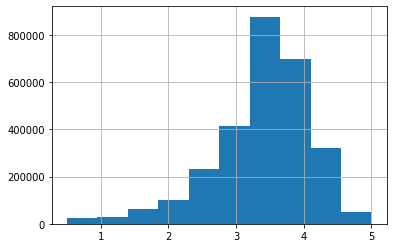

In [7]:
ratebeer['reviewscore'].hist()

<AxesSubplot:>

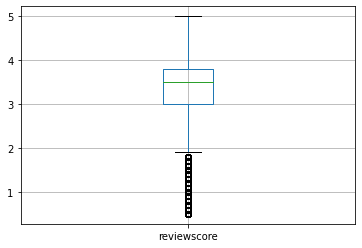

In [8]:
ratebeer[['reviewscore']].boxplot()

In [9]:
len(ratebeer)

2808429

### preprocessing

In [10]:
def preprocessing_df(df):
    # rating 전처리
    # df['rating/apperance'] = df['review/appearance'].str.split("/").str[0].astype(int)
    # df['rating/aroma'] = df['review/aroma'].str.split("/").str[0].astype(int)
    # df['rating/palate'] = df['review/palate'].str.split("/").str[0].astype(int)
    # df['rating/taste'] = df['review/taste'].str.split("/").str[0].astype(int)
    # df['rating/overall'] = df['review/overall'].str.split("/").str[0].astype(int)
    
    # overall rating 최대치 5로 변환
    # df['rating/overall'] = df['rating/overall'] / 20 * 5
    
    # item, user, rating만 추출
    df = df[['beer_id', 'profile_name', 'reviewscore', 'image_url']]
    df.rename(columns={'beer_id' : 'item', 'profile_name' : 'user', 'reviewscore' : 'rating'}, inplace = True) 
    
    # 유저 리뷰 수 개산
    # df['user/reviewcount'] = df.groupby('user')['user'].transform('count')
    # 리뷰 수가 10개 이상인 유저만 남김 
#     df = df[(df['user/reviewcount'] >= 10)]
    
#     df.drop(columns=['user/reviewcount'], inplace=True)
    
    num_users = df.user.unique().shape[0]
    num_items = df.item.unique().shape[0]
    return df, num_users, num_items

### Statistics of the Dataset

In [11]:
data, num_users, num_items = preprocessing_df(ratebeer)
sparsity = 1 - len(data) / (num_users * num_items)
print(f'number of users: {num_users}, number of items: {num_items}')
print(f'matrix sparsity: {sparsity:f}')
print(data.head())

number of users: 13231, number of items: 9335
matrix sparsity: 0.977262
     item        user  rating  \
0  131594   jmgreenuk     3.9   
1  131594         Ron     3.9   
2  131594     olberic     4.1   
3  131594  bergstaden     4.1   
4  131594      ZayZay     4.0   

                                           image_url  
0  https://res.cloudinary.com/ratebeer/image/uplo...  
1  https://res.cloudinary.com/ratebeer/image/uplo...  
2  https://res.cloudinary.com/ratebeer/image/uplo...  
3  https://res.cloudinary.com/ratebeer/image/uplo...  
4  https://res.cloudinary.com/ratebeer/image/uplo...  


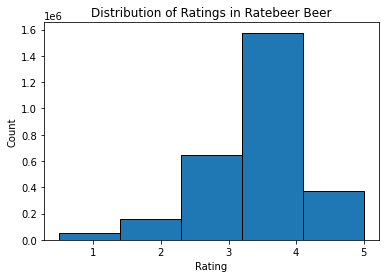

In [184]:
plt.hist(data['rating'], bins=5, ec='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings in Ratebeer Beer')
plt.show()

### Label Encoding

In [13]:
user_le = LabelEncoder()
item_le = LabelEncoder()
data['user_id_idx'] = user_le.fit_transform(data['user'].values)
data['item_id_idx'] = item_le.fit_transform(data['item'].values)

# data.drop(columns=['user', 'item_id'], inplace=True)

### Loading the data

In [14]:
class BeerDataset(Dataset):
    def __init__(self, df, mode='train'):
        self.df = df
        self.mode = mode
        self.train_size = 0.9
        self.val_size = 0.1
        # self.test_size = 1 - self.train_size - self.val_size 

        self.num_items = len(self.df['item_id_idx'].unique())
        self.num_users = len(self.df['user_id_idx'].unique())
        
        n_val = int(self.num_users * self.val_size)
#         n_test = int(self.num_users * self.test_size)
        
        np.random.seed(42)
        
        val_indices = set(np.random.choice(range(self.num_users), n_val, replace = False))
        # test_indices = set(random.choices(list(set(range(self.num_users)) - val_indices), k=n_test))
        train_indices = set(range(self.num_users)) - val_indices # - test_indices
#         # self.train_df, self.test_df = train_test_split(self.df, test_size=self.test_size, train_size=self.train_size, stratify = self.df['user_id_idx'].values, random_state=42)
        
        if self.mode == 'train':
            self.df = self.df[self.df['user_id_idx'].isin(train_indices)]
        elif self.mode == 'val':
            self.df = self.df[self.df['user_id_idx'].isin(val_indices)]
#         else:
#             self.df = self.df[self.df['user_id_idx'].isin(test_indices)]
        
        # 유저 리뷰 수 개산
        # self.df['user/reviewcount'] = self.df.groupby('user_id_idx')['user_id_idx'].transform('count')
        
        # #리뷰 수가 4개 이상인 유저만 남김 
        # self.df = self.df[(self.df['user/reviewcount'] > 3)]
        # self.df.drop(columns=['user/reviewcount'], inplace=True)
        
        self.users = torch.tensor(self.df['user_id_idx'].values)
        self.items = torch.tensor(self.df['item_id_idx'].values)
        self.ratings = torch.tensor(self.df['rating'].values)
        
        self.inter_mat = self.make_inter_mat()
    
    def make_inter_mat(self):
        inter_mat = np.zeros((self.num_users, self.num_items))
        for user, item, rating in zip(self.users, self.items, self.ratings):
            inter_mat[user][item] = rating
            
        # for user in self.users:
        #     nonzero_ind = np.where(inter_mat[user] > 0)[0]
        #     # if len(nonzero_ind) > 3:
        #     valid_ind = np.random.choice(nonzero_ind, 3, replace = False)
        #     if self.mode == 'train':
        #         inter_mat[user][valid_ind] = 0
        #     else:
        #         inter_mat[user][np.setdiff1d(nonzero_ind, valid_ind)] = 0

        return inter_mat

    def __len__(self):
        # return len(self.users)
        return len(self.inter_mat)

    def __getitem__(self, index):
        # inter_mat = torch.tensor(self.inter_mat[self.users[index]]).float()
        inter_mat = torch.tensor(self.inter_mat[index]).float()

        return index, inter_mat

### Autorec Model

In [15]:
class AutoRec(nn.Module):
    def __init__(self, num_hidden, num_items, dropout=0.2):
        super(AutoRec, self).__init__()
        self.encoder = nn.Linear(num_items, num_hidden)
        self.activate = nn.Sigmoid()
        self.decoder = nn.Linear(num_hidden, num_items)
        self.dropout = nn.Dropout(dropout)

    def forward(self, mat):
        hidden = self.dropout(self.activate(self.encoder(mat)))
        pred = self.decoder(hidden)
        
        return pred

###  Model train, validcation

In [16]:
def train(model, train_iter, criterion, optm, device):
    model.train() # to train mode
    loss_sum = 0

    for _, inter_mat in train_iter:
        inter_mat = inter_mat.to(device)    

        preds = model(inter_mat)
        loss = criterion(preds, inter_mat)

        # Update
        optm.zero_grad()      # reset gradient 
        loss.backward()      # backpropagate
        optm.step()      # optimizer update
        
        loss_sum += loss.item()

    loss_avg = loss_sum / len(train_iter)

    return loss_avg

In [171]:
def validation(model, valid_iter, criterion, device):
    
    # np.random.seed(42)
    
    with torch.no_grad():
        model.eval()
        loss_sum = 0
        loss_cal_count = 0
        
        for _, inter_mat in valid_iter:
            inter_mat = inter_mat.to(device)
            
            # matrix 값 중 0보다 큰 값만 추출
            y_for_compute = inter_mat.squeeze().cpu().numpy()
            index = np.where(y_for_compute > 0)[0]
            
            # 0보다 큰 값 중 n_val개를 masking
            n_val = min(int(len(index) * 0.1), 3)
            valid_ind = np.random.choice(index, n_val, replace = False)
            y_for_compute[valid_ind] = 0
            
            # n_val개 masking 된 input 생성
            masked_input = torch.tensor(y_for_compute).to(device).unsqueeze(0)
            
            # 정답지는 input에서 masking 되지 않은 위치를 masking  
            if len(index):
                # print(len(index))
                # print(valid_ind)
                # print(index)
                mat_masked_idx = np.array([i for i in index if i not in valid_ind]) 
                # print(mat_masked_idx)
                inter_mat = inter_mat.squeeze().cpu().numpy()
                inter_mat[mat_masked_idx] = 0
                inter_mat = torch.tensor(inter_mat).to(device).unsqueeze(0)
            
            # mask된 input으로 prediction 후 기존 정답 활용 loss값 계산
            preds = model(masked_input)
            loss = criterion(preds, inter_mat)
            
            if not np.isnan(loss.cpu().numpy()):
                loss_cal_count += 1
                loss_sum += loss.item()
            
        loss_avg = loss_sum / loss_cal_count
        
    return loss_avg

In [172]:
class AutoRec_loss_fn(nn.Module):

    def __init__(self, loss_fn):
        super(AutoRec_loss_fn, self).__init__()
        self.loss_fn = loss_fn
    
    def forward(self, pred, y):
        y_for_compute = y.clone().to('cpu')
        index = np.where(y_for_compute > 0) # FILL HERE : USE np.where & y_for_compute. WARNING: y를 사용 시, y의 device가 gpu일 경우 오류 발생 #
        loss = self.loss_fn(pred[index], y[index])
        return loss

In [173]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

num_epochs = 25
lr = 0.001
batch_size = 64

PATH = '../model/autorec_exp_rmse.pt'
patience = 5

num_items = data.item_id_idx.nunique()
num_hidden = 500

In [174]:
train_dataset = BeerDataset(df=data, mode='train')
val_dataset = BeerDataset(df=data, mode='val')

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True) 
val_dataloader = DataLoader(dataset=val_dataset, batch_size=1, shuffle=False)

In [175]:
model = AutoRec(num_hidden, num_items).to(device)
loss = AutoRec_loss_fn(nn.MSELoss().to(device)).to(device)
optm = optim.Adam(model.parameters(),lr=lr)

In [176]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

  4%|▋               | 1/25 [00:15<06:09, 15.38s/it]

Validation loss decreased (inf --> 0.550437).  Saving model ...
epoch: 0, train Loss: 0.6982, test Loss: 0.5504


  8%|█▎              | 2/25 [00:30<05:52, 15.31s/it]

Validation loss decreased (0.550437 --> 0.453848).  Saving model ...
epoch: 1, train Loss: 0.3519, test Loss: 0.4538


 12%|█▉              | 3/25 [00:45<05:32, 15.11s/it]

Validation loss decreased (0.453848 --> 0.433204).  Saving model ...
epoch: 2, train Loss: 0.3361, test Loss: 0.4332


 16%|██▌             | 4/25 [01:00<05:15, 15.01s/it]

Validation loss decreased (0.433204 --> 0.415158).  Saving model ...
epoch: 3, train Loss: 0.3189, test Loss: 0.4152


 20%|███▏            | 5/25 [01:15<05:00, 15.02s/it]

Validation loss decreased (0.415158 --> 0.390789).  Saving model ...
epoch: 4, train Loss: 0.2959, test Loss: 0.3908


 24%|███▊            | 6/25 [01:30<04:45, 15.02s/it]

EarlyStopping counter: 1 out of 5
epoch: 5, train Loss: 0.2810, test Loss: 0.4026


 28%|████▍           | 7/25 [01:45<04:28, 14.92s/it]

Validation loss decreased (0.390789 --> 0.380128).  Saving model ...
epoch: 6, train Loss: 0.2640, test Loss: 0.3801


 32%|█████           | 8/25 [01:59<04:13, 14.89s/it]

EarlyStopping counter: 1 out of 5
epoch: 7, train Loss: 0.2532, test Loss: 0.3827


 36%|█████▊          | 9/25 [02:14<03:58, 14.88s/it]

Validation loss decreased (0.380128 --> 0.358291).  Saving model ...
epoch: 8, train Loss: 0.2432, test Loss: 0.3583


 40%|██████         | 10/25 [02:29<03:42, 14.84s/it]

EarlyStopping counter: 1 out of 5
epoch: 9, train Loss: 0.2344, test Loss: 0.3901


 44%|██████▌        | 11/25 [02:44<03:28, 14.87s/it]

EarlyStopping counter: 2 out of 5
epoch: 10, train Loss: 0.2267, test Loss: 0.4046


 48%|███████▏       | 12/25 [02:59<03:13, 14.88s/it]

EarlyStopping counter: 3 out of 5
epoch: 11, train Loss: 0.2235, test Loss: 0.3964


 52%|███████▊       | 13/25 [03:14<02:58, 14.86s/it]

EarlyStopping counter: 4 out of 5
epoch: 12, train Loss: 0.2165, test Loss: 0.4163


 52%|███████▊       | 13/25 [03:28<03:12, 16.07s/it]

EarlyStopping counter: 5 out of 5
Early stopping


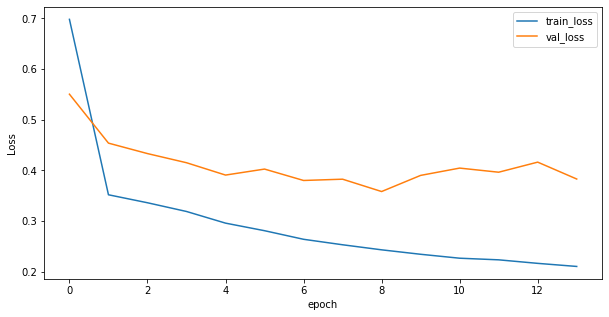

In [177]:
train_losses = []
val_losses = []

early_stopping = EarlyStopping(patience = patience, verbose = True, path=PATH)

for epoch in tqdm(range(num_epochs)):

    train_loss = train(model, train_dataloader, loss, optm, device)
    val_loss = validation(model, val_dataloader, loss, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break
        
    print(f'epoch: {epoch}, train Loss: {train_loss:.4f}, test Loss: {val_loss:.4f}')

plt.figure(figsize=(10,5))
plt.plot(train_losses,label="train_loss")
plt.plot(val_losses,label="val_loss")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [24]:
train_dataset.inter_mat.shape

(13231, 9335)

In [24]:
# PATH = '../model/autorec_exp_rmse.pt'
# torch.save(model.state_dict(), PATH)

## inference

### 모델 불러오기

In [144]:
model = AutoRec(num_hidden, num_items).to(device)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

### 평가지표 함수

In [86]:
def ndcg_k(actual, predicted, topk):
    res = 0
    for user_id in range(len(actual)):
        k = min(topk, len(actual[user_id]))
        idcg = idcg_k(k)
        dcg_k = sum(
            [
                int(predicted[user_id][j] in set(actual[user_id])) / math.log(j + 2, 2)
                for j in range(topk)
            ]
        )
        res += dcg_k / idcg
    return res / float(len(actual))

# Calculates the ideal discounted cumulative gain at k
def idcg_k(k):
    res = sum([1.0 / math.log(i + 2, 2) for i in range(k)])
    if not res:
        return 1.0
    else:
        return res

def recall_at_k(actual, predicted, topk):
    sum_recall = 0.0
    num_users = len(predicted)
    true_users = 0
    for i in range(num_users):
        act_set = set(actual[i])
        pred_set = set(predicted[i][:topk])
        if len(act_set) != 0:
            sum_recall += len(act_set & pred_set) / float(len(act_set))
            true_users += 1
    return sum_recall / true_users

In [87]:
def inference(model, test_iter, test_matrix, device, topk = 4):
    pred_list = None
    answer_list = None
    with torch.no_grad():
        model.eval()

        for i, (user_ids, inter_mat) in enumerate(test_iter):
            inter_mat = inter_mat.to(device)
            
            rating_pred = model(inter_mat)
            
            rating_pred = rating_pred.cpu().data.numpy().copy()
            
            batch_user_index = user_ids.cpu().numpy()
            answers = test_matrix.argsort(axis = 1)[batch_user_index, -topk:][:, ::-1]
            # rating_pred[test_matrix[batch_user_index] > 0] = 0
            
            ind = np.argpartition(rating_pred, -topk)[:, -topk:]
            
            arr_ind = rating_pred[np.arange(len(rating_pred))[:, None], ind]

            arr_ind_argsort = np.argsort(arr_ind)[np.arange(len(rating_pred)), ::-1]

            batch_pred_list = ind[
                np.arange(len(rating_pred))[:, None], arr_ind_argsort
            ]

            if i == 0:
                pred_list = batch_pred_list
                answer_list = answers
            else:
                pred_list = np.append(pred_list, batch_pred_list, axis=0)
                answer_list = np.append(
                        answer_list, answers, axis=0
                )
            
        recall = recall_at_k(answer_list, pred_list, topk)
        ndcg = ndcg_k(answer_list, pred_list, topk)
        
        print(f'recall@{topk} = {recall}, ndcg@{topk} = {ndcg}')
    return pred_list, answer_list

In [88]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

num_epochs = 25
lr = 0.001
batch_size = 1

num_items = data.item_id_idx.nunique()
num_hidden = 40

In [89]:
test_dataset = BeerDataset(df=data, mode='test')

test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

test_matrix = test_dataset.inter_mat

### inference 수행

In [59]:
pred_list, answer_list = inference(model, test_dataloader, test_matrix, device, topk=4)

recall@4 = 0.05295659772793475, ndcg@4 = 0.061438824849315406


In [60]:
# test 데이터 user 목록
test_dataset.df.user_id_idx.unique()

array([14420,  2619, 12238, ...,  7819, 14540,  3600])

In [61]:
# 모델 예측 선호 맥주 top4
pred_list[14420]

array([58, 55, 19,  9])

In [62]:
# 유저 실제 선호 맥주 top4
answer_list[14420]

array([58, 19, 55, 15])

In [63]:
test_matrix[14420]

array([1.9, 0. , 0. , 1.5, 2.2, 2.1, 3.5, 1.9, 1.4, 3.4, 2.8, 0. , 0. ,
       3.3, 0. , 3.6, 1.7, 1.6, 3.5, 3.8, 2.8, 2.2, 0. , 2.9, 3. , 3. ,
       3.4, 3.3, 0. , 0. , 2. , 2.4, 0. , 1.8, 0. , 2.3, 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 3.2, 0. , 0. , 0. , 0. , 3. ,
       3.1, 0. , 1.9, 3.7, 2. , 0. , 3.8, 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 3. , 1.8, 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. ])

### 웹사이트 inference

In [252]:
# show_list = np.random.choice(81, 30, replace = False)

In [253]:
# show_list

array([26,  8, 45, 12, 53, 21, 44, 43,  3, 71, 49, 29, 11, 66, 54, 55, 15,
       30, 14, 18, 39, 63, 68, 19, 79, 42,  4, 20, 76, 22])

In [254]:
# x_test = torch.zeros(81)
# x_test

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [255]:
# for beer in show_list:
#     x_test[beer] = random.choice(rating_list)
# x_test

tensor([0.0000, 0.0000, 0.0000, 2.8000, 0.5000, 0.0000, 0.0000, 0.0000, 0.5000,
        0.0000, 0.0000, 0.5000, 5.0000, 0.0000, 0.5000, 0.5000, 0.0000, 0.0000,
        2.8000, 2.8000, 5.0000, 2.8000, 2.8000, 0.0000, 0.0000, 0.0000, 0.5000,
        0.0000, 0.0000, 2.8000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 5.0000, 0.0000, 0.0000, 0.5000, 2.8000, 0.5000,
        2.8000, 0.0000, 0.0000, 0.0000, 5.0000, 0.0000, 0.0000, 0.0000, 5.0000,
        0.5000, 5.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.5000, 0.0000, 0.0000, 5.0000, 0.0000, 0.5000, 0.0000, 0.0000, 5.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 5.0000, 0.0000, 0.0000, 2.8000, 0.0000])

In [256]:
# show_df = data[data['item_id_idx'].isin(show_list)]

In [257]:
# not_show_list = np.delete(np.arange(81), show_list)
# not_show_list

array([ 0,  1,  2,  5,  6,  7,  9, 10, 13, 16, 17, 23, 24, 25, 27, 28, 31,
       32, 33, 34, 35, 36, 37, 38, 40, 41, 46, 47, 48, 50, 51, 52, 56, 57,
       58, 59, 60, 61, 62, 64, 65, 67, 69, 70, 72, 73, 74, 75, 77, 78, 80])

In [258]:
# for i in not_show_list:
#     style = data[data['item_id_idx'] == i]['label'].unique()[0]
#     rating = show_df[show_df['label'] == style]['rating'].mean()
#     if np.isnan(rating):
#         rating = rating_list[1] # style로 점수를 채울 수 없는 경우 몰라요로 채운다
#     x_test[i] = rating
# x_test

tensor([2.1645, 2.8000, 2.1645, 2.8000, 0.5000, 2.8000, 3.1620, 2.1645, 0.5000,
        3.5909, 2.1645, 0.5000, 5.0000, 2.5330, 0.5000, 0.5000, 2.1645, 2.1645,
        2.8000, 2.8000, 5.0000, 2.8000, 2.8000, 3.1620, 3.5909, 3.5909, 0.5000,
        2.8000, 2.1645, 2.8000, 0.5000, 2.1645, 2.8000, 2.1645, 2.1645, 2.1645,
        2.5330, 2.5330, 2.1645, 5.0000, 2.1645, 2.1645, 0.5000, 2.8000, 0.5000,
        2.8000, 3.1620, 2.1645, 2.8000, 5.0000, 2.1645, 2.8000, 3.5909, 5.0000,
        0.5000, 5.0000, 2.5330, 2.8000, 3.5131, 3.1620, 2.1645, 3.5909, 2.5330,
        0.5000, 2.1645, 2.8000, 5.0000, 2.8000, 0.5000, 2.8000, 2.1645, 5.0000,
        2.8000, 2.8000, 2.8000, 3.0375, 5.0000, 2.8000, 3.5909, 2.8000, 3.5909])

In [145]:
kor_beer_list = np.array([ 75661, 614833, 169964,    251,  10726,   5588,   5571,   6668,
         7656,  36249,    709,   4007,  72025,  58275, 221535, 291276,
         2469,    721,  30913,  75071,     55,  17334, 493355,  64253,
        34662, 506847,  73158,   5159,   3101, 315443,    268,    390,
        71469,  35424,   4701, 288954, 136785, 632627,   3029, 553245,
       580686, 252000,  21936, 667837,   2811,    729,  71458,  86387,
       146878, 146725, 149060,  15747,   3126, 480225, 268685, 211962,
        64518, 621308,   7580, 452525,   1486,    221,   1417,    730,
         1478,    717,    647,    405,   2516,   2514,    399,     37,
          715,    814,   1088,   2468,    742,    473, 135361,   2228,
          703])

kor_ratebeer = ratebeer[ratebeer['beer_id'].isin(kor_beer_list)]

In [146]:
kor_beer_idx = data[data['item'].isin(kor_beer_list)]['item_id_idx'].unique()

In [147]:
np.arange(0.5, 5.5, 0.5)

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

In [148]:
np.delete(np.arange(num_item), kor_beer_idx)

array([   0,    1,    2, ..., 9315, 9316, 9317])

In [170]:
# 웹사이트 input
# x_test = torch.tensor([1.9, 0. , 0. , 1.5, 2.2, 2.1, 3.5, 1.9, 1.4, 3.4, 2.8, 0. , 0. ,
#        3.3, 0. , 3.6, 1.7, 1.6, 3.5, 3.8, 2.8, 2.2, 0. , 2.9, 3. , 3. ,
#        3.4, 3.3, 0. , 0. , 2. , 2.4, 0. , 1.8, 0. , 2.3, 0. , 0. , 0. ,
#        0. , 0. , 0. , 0. , 0. , 0. , 0. , 3.2, 0. , 0. , 0. , 0. , 3. ,
#        3.1, 0. , 1.9, 3.7, 2. , 0. , 3.8, 0. , 0. , 0. , 0. , 0. , 0. ,
#        0. , 0. , 0. , 0. , 0. , 3. , 1.8, 0. , 0. , 0. , 0. , 0. , 0. ,
#        0. , 0. , 0. ]).to(device)

num_item = data['item'].nunique()

# 한국 맥주 평가
rating_list = [5.0, 2.8, 0.5] # 좋아요, 몰라요, 싫어요
kor_beer_idx = data[data['item'].isin(kor_beer_list)]['item_id_idx'].unique()
show_list = np.random.choice(kor_beer_idx, 30, replace=False) # 임의로 30개 추출
x_test = torch.zeros(num_item).to(device) # 0으로 초기화

for beer in show_list:
    x_test[beer] = random.choice(rating_list) # 30개에 대해서 임의로 평가
    
# show_df = data[data['item_id_idx'].isin(show_list)]

# 나머지 맥주 중 일부 평가
not_kor_rating_list = np.arange(0.5, 5.5, 0.5)
not_kor_idx = np.delete(np.arange(num_item), kor_beer_idx)
not_kor_list = np.random.choice(not_kor_idx, int(len(not_kor_idx) * 0.1) , replace=False) 

for beer in not_kor_list:
    x_test[beer] = random.choice(not_kor_rating_list)

# for i in not_show_list:
#     style = data[data['item_id_idx'] == i]['label'].unique()[0]
#     rating = show_df[show_df['label'] == style]['rating'].mean()
    
#     if np.isnan(rating):
#         rating = rating_list[1] # style로 점수를 채울 수 없는 경우 몰라요로 채운다
#     x_test[i] = rating
#     # print(rating)

# 추천 맥주 개수
topk = 4

# 모델 에측 맥주 평점
rating_pred = model(x_test)

rating_pred = rating_pred.cpu().data.numpy().copy()
# print(rating_pred)

rating_pred = rating_pred[kor_beer_idx]
x_test = x_test[kor_beer_idx]
# batch_user_index = user_ids.cpu().numpy()


answers = x_test.cpu().numpy().argsort()[-topk:][::-1]
# print(answers)

# user가 리뷰를 남긴 맥주 추천하고 싶지 않을 때 사용

# if novelty:
# 좋아요, 싫어요로 직접 평가한 맥주는 다시 추천하지 않도록 설정
rating_pred[x_test.cpu().numpy() == rating_list[0]] = 0
rating_pred[x_test.cpu().numpy() == rating_list[2]] = 0
# print(rating_pred)

# topk 맥주 index
ind = np.argpartition(rating_pred, -topk)[-topk:]
# print(ind)

# topk 맥주 index별 평점
arr_ind = rating_pred[ind]
# print(arr_ind)

# 평점 기준으로 내림차순으로 정렬
arr_ind_argsort = np.argsort(arr_ind)[::-1]
# print(arr_ind_argsort)

# rating 내림차순 모델 예측 topk 맥주 index 
topk_pred_list = ind[arr_ind_argsort]
print(topk_pred_list)

# rating 내림차순 모델 예측 맥주 평점 중 topk개
topk_rating_list = rating_pred[topk_pred_list] #rating_pred[np.arange(len(rating_pred))[:, None], ind]
print(topk_rating_list)

[ 9 19 38 29]
[3.5332427 3.5163522 3.4324605 3.3487043]


In [150]:
# 모델 예측 선호 맥주 top4
topk_pred_list

array([38, 19, 52, 30])

In [151]:
# 유저 실제 선호 맥주 top4
answers

array([16, 77, 34, 35])

In [152]:
rating_pred[topk_pred_list]

array([3.4209647, 3.3806093, 3.3294287, 3.3096955], dtype=float32)

In [153]:
label_list = ['good', 'unknown', 'bad']

for i, rating in enumerate(rating_list):
    print(label_list[i])
    print(list(sorted([rating_pred[i] for i in np.where(x_test.cpu().numpy() == rating)[0]], reverse=True)))
    print()

good
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

unknown
[3.1390154, 2.9578788, 2.6885693, 2.366922, 2.3635569, 2.126513, 1.8678279, 1.5981327, 1.3306361, 1.0609407]

bad
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]



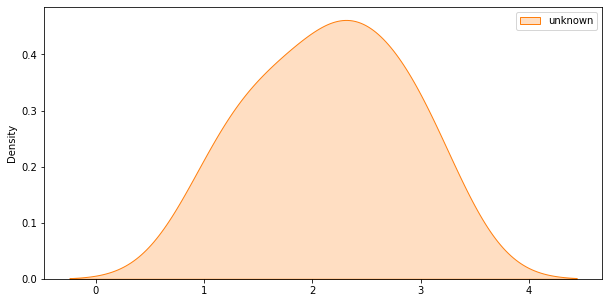

In [154]:
label_list = ['good', 'unknown', 'bad']

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for i, rating in enumerate(rating_list):
    
    ax = sns.kdeplot(sorted([rating_pred[i] for i in np.where(x_test.cpu().numpy() == rating)[0]], reverse=True), label = label_list[i], fill = True)

plt.legend()
plt.show()

<AxesSubplot:ylabel='Count'>

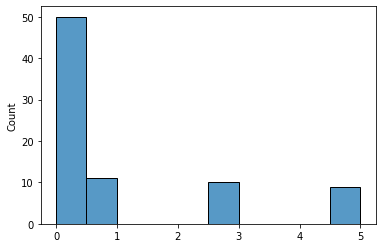

In [155]:
sns.histplot(x_test.cpu().numpy(), bins = 10)

<AxesSubplot:ylabel='Count'>

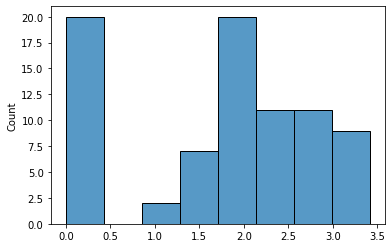

In [156]:
sns.histplot(rating_pred)

In [157]:
# 모델 예측 rating 점수
rating_pred

array([1.4724944, 2.5048585, 2.6916757, 1.8473616, 1.9333318, 2.9928658,
       0.       , 0.       , 1.0609407, 3.269311 , 1.9110364, 2.0773952,
       0.       , 2.8757148, 2.4127142, 1.8022404, 0.       , 1.3306361,
       0.       , 3.3806093, 2.2658656, 2.3569367, 2.366922 , 1.7269574,
       2.4274683, 2.6952438, 0.       , 2.7207973, 2.9087462, 3.0110261,
       3.3096955, 0.       , 2.0088189, 1.6940594, 0.       , 0.       ,
       0.       , 1.3019787, 3.4209647, 2.221292 , 2.1975222, 1.980085 ,
       1.6719086, 2.046482 , 2.9578788, 2.0903986, 3.1886268, 1.8678279,
       0.       , 2.0859718, 0.       , 1.9188781, 3.3294287, 1.9870416,
       2.2455173, 1.8538606, 0.       , 2.0140269, 0.       , 0.       ,
       1.5981327, 0.       , 2.6885693, 0.       , 2.126513 , 2.6851337,
       2.3635569, 2.101599 , 3.034761 , 1.8858762, 3.1390154, 1.6498015,
       0.       , 2.4805458, 1.152667 , 1.7970858, 2.631058 , 0.       ,
       2.6861198, 0.       ], dtype=float32)

In [158]:
x_test

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.0000, 0.5000, 2.8000,
        0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 5.0000, 2.8000,
        5.0000, 0.0000, 0.0000, 0.0000, 2.8000, 0.0000, 0.0000, 0.0000, 0.5000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 5.0000, 5.0000,
        5.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.8000,
        0.0000, 0.0000, 2.8000, 0.5000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.5000, 0.0000, 0.5000, 0.5000, 2.8000, 0.5000, 2.8000,
        5.0000, 2.8000, 0.0000, 2.8000, 0.0000, 0.0000, 0.0000, 2.8000, 0.0000,
        5.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.0000, 0.0000, 0.5000],
       device='cuda:0')

In [83]:
# np.where(x_test.cpu().numpy() == 0.5)[0]

In [36]:
# set(np.where(x_test.cpu().numpy() == 0.5)[0]) & set(np.where(rating_pred < 2.0)[0])

{2, 9, 12, 24, 28, 30, 37, 42, 45, 48, 52, 56, 64, 72, 76}

In [48]:
# rating_pred[21]

-4.3385754

In [159]:
kor_beer_idx

array([  23,   37,  132,  148,  159,  201,  205,  210,  258,  364,  405,
        410,  414,  415,  417,  419,  420,  432,  450,  553,  673, 6650,
        692,  695, 9328, 4850,  866,  981,  982, 1001, 1003, 4886, 1078,
       1128, 1144, 1147, 4924, 1339, 9038, 1503, 1612, 1697, 1705, 9072,
       6652, 9318, 6686, 9322, 1945, 2170, 6740, 2186, 6813, 9333, 6835,
       2834, 9334, 6282, 9329, 9319, 9234, 3545, 9237, 3721, 9253, 4664,
       9325, 7341, 9327, 4050, 9321, 9320, 9331, 6011, 9326, 9323, 9330,
       9324, 9332, 6276])

In [160]:
# image url
data[data['item_id_idx'].isin(kor_beer_idx[topk_pred_list])]['image_url'].unique()

array(['https://res.cloudinary.com/ratebeer/image/upload/w_400,c_limit,d_Default_Beer_qqrv7k.png,f_auto/beer_1088',
       'https://res.cloudinary.com/ratebeer/image/upload/w_400,c_limit,d_Default_Beer_qqrv7k.png,f_auto/beer_2516',
       'https://res.cloudinary.com/ratebeer/image/upload/w_400,c_limit,d_Default_Beer_qqrv7k.png,f_auto/beer_135361',
       'https://res.cloudinary.com/ratebeer/image/upload/w_400,c_limit,d_Default_Beer_qqrv7k.png,f_auto/beer_75071'],
      dtype=object)

In [161]:
# 맥주 이름
data[data['item_id_idx'].isin(kor_beer_idx[topk_pred_list])]['item'].unique()

array([  1088,   2516, 135361,  75071])

### 평가지표 점수

In [141]:
def ndcg_k_inf(actual, predicted, topk):
    res = 0
    k = min(topk, len(actual))
    idcg = idcg_k(k)
    dcg_k = sum(
        [
            int(predicted[j] in set(actual)) / math.log(j + 2, 2)
            for j in range(topk)
        ]
    )
    res += dcg_k / idcg
    return res / float(len(actual))

# Calculates the ideal discounted cumulative gain at k
def idcg_k(k):
    res = sum([1.0 / math.log(i + 2, 2) for i in range(k)])
    if not res:
        return 1.0
    else:
        return res

def recall_at_k_inf(actual, predicted, topk):
    act_set = set(actual)
    pred_set = set(predicted[:topk])
    if len(act_set) != 0:
        sum_recall = len(act_set & pred_set) / float(len(act_set))
        
    return sum_recall

In [142]:
recall_at_k_inf(answers, topk_pred_list, 4)

0.0

In [143]:
ndcg_k_inf(answers, topk_pred_list, 4)

0.0

In [144]:
data

,item,user,rating,imageUrl,user/reviewcount,user_id_idx,item_id_idx
0,75661,Grzesiek79,1.3,https://res.cloudinary.com/ratebeer/image/uplo...,55,3051,56
1,75661,GriZZZly,2.7,https://res.cloudinary.com/ratebeer/image/uplo...,13,3028,56
2,75661,bdleedahl,3.3,https://res.cloudinary.com/ratebeer/image/uplo...,31,8450,56
3,75661,DoctorHU,2.6,https://res.cloudinary.com/ratebeer/image/uplo...,48,2153,56
4,75661,McTapps,2.5,https://res.cloudinary.com/ratebeer/image/uplo...,49,4783,56
...,...,...,...,...,...,...,...
93615,703,Bov,3.0,https://res.cloudinary.com/ratebeer/image/uplo...,46,1215,10
93616,703,sallyclub99,4.2,https://res.cloudinary.com/ratebeer/image/uplo...,7,15196,10
93617,703,kublai3,2.7,https://res.cloudinary.com/ratebeer/image/uplo...,6,12689,10
93618,703,Aubrey,3.3,https://res.cloudinary.com/ratebeer/image/uplo...,23,520,10


In [40]:
data.to_csv('../data/ratebeer_label_encoding.csv', index = False)